# Pipeline for clustering analysis of protein sequences

## 1. Dataset
- Lysozyme CGCh dataset contains fasta file of Lysozyme C, Lysozyme G, and Lysozyme Ch protein families
- Lysozyme C, Lysozyme G, and Lysozyme Ch are labels

## 2. Preprocessing
- Removes duplicate sequences within and between protein families
- Eliminates sequences containing non-standard amino acids (UZOBJX)
- Optional: Removes outliers based on sequence length
- Optional: Filters sequences below length threshold

## 3. Feature Extraction
- Uses Pseudo Amino Acid Composition (PAAC)
- Considers physicochemical properties:
    - Hydrophobicity
    - Hydrophilicity
    - Mass

## 4. Clustering Analysis
Implements multiple clustering algorithms:
- KMeans
- Agglomerative
- Gaussian Mixture
- Spectral
- Affinity Propagation
- DBSCAN
- OPTICS
- Mean-shift
- BIRCH

## 5. Evaluation Metrics
### Intrinsic Metrics
- Silhouette Coefficient (SC)
- Calinski-Harabasz Index (CH)
- Davies-Bouldin Index (DB)

### Extrinsic Metrics
- Fowlkes-Mallows Index (FMI)
- F1 Score
- Matthews Correlation Coefficient (MCC)
- Adjusted Mutual Information (AMI)
- Contingency matrix

In [2]:
# import libraries
import os
os.environ['OMP_NUM_THREADS'] = '1' # set the number of threads to 1 to avoid warning message
import time
from collections import defaultdict, Counter
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import cluster, mixture, manifold, decomposition, metrics, preprocessing # https://scikit-learn.org/stable/modules/clustering.html
import numpy as np
import pandas as pd 
import warnings
from sklearn.exceptions import ConvergenceWarning # to suppress warning message 
warnings.filterwarnings("ignore", category=ConvergenceWarning, message="Number of subclusters found.*by BIRCH.*")

## 1. Dataset
- Lysozyme CGCh dataset contains fasta file of Lysozyme C, Lysozyme G, and Lysozyme Ch protein families
- Lysozyme C, Lysozyme G, and Lysozyme Ch are labels

In [3]:
dataset = 'Lysozyme_CGCCh' # dataset name
# protein_families is a dictionary with fasta file path as key and protein family as value
protein_families = {'Lysozyme_CGCh/Lysozyme_C.txt':'Lysozyme_C',
                    'Lysozyme_CGCh/Lysozyme_G.txt':'Lysozyme_G',
                    'Lysozyme_CGCh/Lysozyme_Ch.txt':'Lysozyme_Ch'}

## 2.1. Preprocessing
- Removes duplicate sequences within and between protein families
- Eliminates sequences containing non-standard amino acids (UZOBJX)

In [4]:
# Preprocessing the data
class preprocessing_step:
    def __init__(self, protein_families):
        fasta_sequences = {}
        duplicate_accession = {}

        # reading the file
        for fasta_file, label in protein_families.items():
            fasta = []
            with open(fasta_file,'r') as file:
                for each_line in file:
                    fasta.append(each_line.strip())

            # convert multiple lines fasta sequence to single line fasta sequence
            single_fasta = self.multiple_fasta_to_single_fasta(fasta)

            # remove duplicates "within" protein family based on accession number
            fasta_sequences[label], duplicate_accession[label] = self.remove_intra_family_duplicates(single_fasta,label)
            print(f'{label}')
            print(f'Total intra-family sequences: {len(single_fasta)//2}, Non-duplicates(accession): {len(fasta_sequences[label])}')

        # remove duplicates "between" protein families based on accession number
        no_duplicate_fasta = self.remove_inter_family_duplicates(fasta_sequences)
        # remove sequences with "UZOBJX" amino acid
        no_uzobjx_fasta = self.remove_UZOBJX(no_duplicate_fasta)
        # final preprocessed fasta data
        self.all_fasta, self.all_fasta_length = self.final_preprocessed_fasta_data(no_uzobjx_fasta)
        print('Total number of protein sequences in the dataset:',len(self.all_fasta)//2)

    # function to final get preprocessed fasta data
    def final_preprocessed_fasta_data(self, no_uzobjx_fasta):
        fasta = []
        fasta_length = {}
        for i in no_uzobjx_fasta:
            fasta_length[i] = []
            for j in no_uzobjx_fasta[i]:
                fasta.append(j+'$'+i) # store the accession number with labels (protein family) separated by '$'
                fasta.append(no_uzobjx_fasta[i][j]) # store the sequence
                fasta_length[i].append(len(no_uzobjx_fasta[i][j])) # store the length of the sequence
        return fasta, fasta_length

    # function to remove sequences with "UZOBJX" amino acid
    def remove_UZOBJX(self, fasta_sequences):
        c = 0
        for i in fasta_sequences:
            for j in list(fasta_sequences[i]):
                if any(aa in fasta_sequences[i][j] for aa in 'UZOBJX'):
                    del fasta_sequences[i][j]
                    c += 1
        print(f'Total sequences after removing UZOBJX: {c}')
        return fasta_sequences

    # function to remove duplicates between protein families based on accession number
    def remove_inter_family_duplicates(self, fasta_sequences):
        all_fasta = []
        for i in fasta_sequences:
            all_fasta += list(fasta_sequences[i])
        c = Counter(all_fasta)
        duplicates = [i for i in c if c[i]>1] # duplicates between protein families and >1 represents the number of times the duplicates are present
        # remove duplicates between protein families
        for i in fasta_sequences:
            for j in duplicates:
                try:
                    del fasta_sequences[i][j]
                except KeyError:
                    pass
        all_sequences = {i:len(fasta_sequences[i]) for i in fasta_sequences}
        print(f'Total sequences after removing inter-family duplicates:\n {all_sequences}')
        return fasta_sequences       

    # function to convert multiple fasta sequence into a single sequence
    def multiple_fasta_to_single_fasta(self,multiple_fasta):
        single_fasta = []
        temp = ''
        for i in multiple_fasta:
            if i.startswith('>'):
                single_fasta.append(temp)
                single_fasta.append(i.rstrip())
                temp = ''
            else:
                temp += i.rstrip()
        single_fasta.append(temp)
        return single_fasta[1:]
    
    # function to remove duplicates within protein family based on accession number
    def remove_intra_family_duplicates(self, single_fasta, label):
        protein_family = {}
        duplicates = []
        # converted the fasta sequence into a dictionary with key as accession number and value as the sequence
        for i in range(0,len(single_fasta),2):
            try:
                protein_family[single_fasta[i]] # check if the accession number exists, if yes then it is a duplicate
                duplicates.append(single_fasta[i]) # store the accession number duplicates
            except KeyError:
                protein_family[single_fasta[i]] = single_fasta[i+1].upper()
        return protein_family, duplicates

# preprocessed_fasta = preprocessing_step(protein_families) # protein_families is a dictionary with fasta file as key and protein family as value
# preprocessed_fasta_data.all_fasta # Contains the preprocessed fasta data

## 2.2. Preprocessing
- Optional: Removes outliers based on sequence length
- Optional: Filters sequences below length threshold

In [5]:
# Optional preprocessing step: 
# 1) Remove outliers based on the lower and upper bounds for the protein sequences length using box-whisker plot
# 2) Remove the sequence below assigned sequence length cut-off
class optional_preprocessing_step:
    def __init__(self, data, len_cut_off):
        # get the outliers, lower and upper bounds for the protein sequences length using box-whisker plot
        box_cut_off = self.box_whisker_plot(data.all_fasta_length)
        print('Outlier cut-off for each protein family:', box_cut_off)
        # remove outliers (sequences) based on the lower and upper bounds from fasta data
        self.no_outlier_fasta = self.remove_outliers(data.all_fasta, box_cut_off)
        #remove the sequence below assigned cut-off
        self.len_filtered_fasta = self.remove_below_cut_off(self.no_outlier_fasta, len_cut_off)

    # function to remove sequences below the cut-off  
    def remove_below_cut_off(self, fasta_data, len_cut_off):
        fasta = []
        for i in range(1,len(fasta_data),2):
            if len(fasta_data[i]) >= len_cut_off:
                pass
                fasta.append(fasta_data[i-1])
                fasta.append(fasta_data[i])
        print(f'Total number of protein sequences below cut-off {len_cut_off}: {len(fasta_data)//2 - len(fasta)//2}')
        return fasta

    # function to remove outliers based on the lower and upper bounds from fasta data
    def remove_outliers(self, fasta_data, box_cut_off):
        fasta = []
        for i in range(0,len(fasta_data),2):
            j = fasta_data[i].split('$')[-1] # get the protein family
            if len(fasta_data[i+1]) >= box_cut_off[j][0] and len(fasta_data[i+1]) <= box_cut_off[j][1]:
                fasta.append(fasta_data[i])
                fasta.append(fasta_data[i+1])
        print('Total number of protein sequences removed as outliers:',len(fasta_data)//2 - len(fasta)//2)
        return fasta
        
    # function to plot box-whisker plot for protein sequence length and get the lower and upper bounds for each protein family
    def box_whisker_plot(self, fasta_length):
        fig =  plt.figure(figsize = (6, 3))
        box_plot_data = plt.boxplot([fasta_length[i] for i in protein_families.values()], tick_labels = protein_families.values())
        plt.xlabel('Protein families')
        plt.ylabel('Sequence length')
        plt.title('Box-whisker plot for protein sequence length')
        plt.show()
   
        cut_off = {}
        # get the lower and upper bounds for each protein family based on sequence length
        caps = [item.get_ydata() for item in box_plot_data['caps']] # get the lower and upper bounds
        cap_index = 0
        for family in protein_families.values():
            bounds = []
            for cap in caps[cap_index:cap_index+2]:
                bounds.append(cap[0])
            cut_off[family] = bounds
            cap_index += 2
        return cut_off
        
# optional_preprocessing_fasta = optional_preprocessing_step(preprocessed_fasta, 200) # 200 is the cut-off for the protein sequence length   

## 3. Feature Extraction
- Uses Pseudo Amino Acid Composition (PAAC)
- Considers physicochemical properties:
    - Hydrophobicity
    - Hydrophilicity
    - Mass

In [6]:
# Feature extraction using pseudo amino acid composition (PAAC)

# Physicochemical properties of amino acids like hydrophobicity, hydrophilicity and mass
physicochemical_properties = {}
physicochemical_properties.update({
    'hydrophobicity': {'A':0.62,'C':0.29,'D':-0.09,'E':-0.74,'F':1.19,'G':0.48,'H':-0.4,'I':1.38,'K':-1.5,'L':1.53,'M':0.64,'N':-0.78,'P':0.12,'Q':-0.85,'R':-2.53,'S':-0.18,'T':-0.05,'V':1.8,'W':0.81,'Y':0.26},
    'hydrophilicity': {'A':-0.5,'C':-1.0,'D':3.0,'E':3.0,'F':-2.5,'G':0.0,'H':-0.5,'I':-1.8,'K':3.0,'L':-1.8,'M':-1.3,'N':0.2,'P':0.0,'Q':0.2,'R':3.0,'S':0.3,'T':-0.4,'V':-1.5,'W':-3.4,'Y':-2.3},
    'mass': {'A':15.0,'C':47.0,'D':59.0,'E':73.0,'F':91.0,'G':1.0,'H':82.0,'I':57.0,'K':73.0,'L':57.0,'M':75.0,'N':58.0,'P':42.0,'Q':72.0,'R':101.0,'S':31.0,'T':45.0,'V':43.0,'W':130.0,'Y':107.0}
}) # hydrophobicity, hydrophilicity and mass of amino acids respectively taken from http://www.csbio.sjtu.edu.cn/bioinf/PseAAC/ParaValue.htm

# function to standardize the physicochemical properties
def standardize_(physicochemical_properties):
    new_physicochemical_properties = {}
    for key, value in physicochemical_properties.items():
        amino_acids = list(value.keys())
        original_values = list(value.values())
        standardized_values = preprocessing.StandardScaler().fit_transform(np.array(original_values).reshape(-1,1)).flatten()
        new_physicochemical_properties[key] = dict(zip(amino_acids, standardized_values))
    return new_physicochemical_properties

standardized_physicochemical_properties = standardize_(physicochemical_properties)

        
# Pseudo amino acid composition (PAAC) feature extraction
class pseudo_amino_acid_composition:
    def __init__(self, fasta_data,lambda_, w):
        self.lambda_ = lambda_
        self.w = w
        self.physicochemical_properties = standardized_physicochemical_properties
        self.amino_acids = {1:'A', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'K', 10:'L', 11:'M', 12:'N', 13:'P', 14:'Q', 15:'R', 16:'S', 17:'T', 18:'V', 19:'W', 20:'Y'}
        collect_features = []
        collect_features.append(['#'] + [aa for aa in self.amino_acids.values()] + [f'\u03BB{i}' for i in range(1,self.lambda_+1)]) # header of the dataframe
        for i in range(0,len(fasta_data),2):
            accessions = fasta_data[i].rstrip()
            paac = self.calculate_paac(fasta_data[i+1].rstrip())
            collect_features.append([accessions]+paac)
        self.df = pd.DataFrame(collect_features[1:], columns=collect_features[0])
        # display(self.df)

    # function to calculate pseudo amino acid composition (PAAC)
    def calculate_paac(self, sequence):
        # Calculating set of sequence order-correlation factors (lower_theta)
        lower_theta = self.calculate_lower_theta(sequence)
        # calculating denominator
        denominator = 1+(self.w*sum(lower_theta.values()))
        # calculating pseudo amino acid composition (PAAC)
        paac = []
        for i in range(1,21+self.lambda_):
            if i>=1 and i <= 20: # for amino acids composition of 20 amino acids
                numerator = sequence.count(self.amino_acids[i])/len(sequence)
                paac.append(numerator/denominator)
            elif i >= 21 and i <= 20+self.lambda_: # for sequence order-correlation factors
                numerator = self.w*lower_theta[i-20] 
                paac.append(numerator/denominator) 
        return paac      

    # function to calculate the sequence order-correlation factors (lower_theta)
    def calculate_lower_theta(self, sequence):
        lower_theta = {}
        for i in range(1,self.lambda_+1):
            # calculate the correlation function (upper_theta) using physicochemical properties
            lower_theta[i] = (1/(len(sequence)-i))*self.calculate_upper_theta(sequence,i)
        return lower_theta
    
    # function to calculate the correlation function (upper_theta) using physicochemical properties
    def calculate_upper_theta(self, sequence, i):
        upper_theta = []
        for j in range(len(sequence)-i):
            physicochemical_diff = []
            for k in self.physicochemical_properties:
                # calculate the difference between the physicochemical properties of amino acids
                l = ((self.physicochemical_properties[k][sequence[j]] - self.physicochemical_properties[k][sequence[j+i]])**2)
                physicochemical_diff.append(l)
            upper_theta.append(sum(physicochemical_diff)/len(self.physicochemical_properties))
        return sum(upper_theta)
                
# PAAC = pseudo_amino_acid_composition(optional_preprocessing_fasta.len_filtered_fasta, 30, 0.05) #

## 4. Clustering Analysis
Implements multiple clustering algorithms:
- KMeans, Agglomerative, Gaussian Mixture, Spectral
- Affinity Propagation, DBSCAN, OPTICS, Mean-shift, BIRCH

## 5. Evaluation Metrics
### Intrinsic Metrics
- Silhouette Coefficient (SC), Calinski-Harabasz Index (CH), Davies-Bouldin Index (DB)

### Extrinsic Metrics
- Fowlkes-Mallows Index (FMI), F1 Score, Matthews Correlation Coefficient (MCC), Adjusted Mutual Information (AMI)
- Contingency matrix

In [10]:
# Clustering 
class clustering:
    def __init__(self, df, k):
        # random seed
        self.seed = 77
        # separate the accession number and the PAAC features
        self.x_values = df.iloc[:,1:].values
        self.y_values = df.iloc[:,0].values
        self.k = k # number of clusters
        self.labels = [i.split('$')[-1] for i in self.y_values] # labels were added to the accession number during preprocessing step (in final_preprocessed_fasta_data function)
        sorted_labels = sorted(set(self.labels)) # sort the labels
        self.true_labels = [sorted_labels.index(i) for i in self.labels] # true labels with 1,2,3,....n labels

    # function of different clustering methods
    # 1) KMeans
    def kmeans(self):
        self.name = 'KMeans'
        km = cluster.KMeans(n_clusters=self.k, random_state=self.seed).fit(self.x_values)
        self.predicted_labels = km.predict(self.x_values)
        return self.metrics() # return dictionary of info about the clustering method and evaluation metrics
    
    # 2) Agglomerative clustering
    def agglomerative(self):
        self.name = 'Agglomerative'
        ag = cluster.AgglomerativeClustering(n_clusters=self.k)
        self.predicted_labels = ag.fit_predict(self.x_values)
        return self.metrics() # return dictionary of info about the clustering method and evaluation metrics
    
    # 3) Gaussian mixture
    def gaussian_mixture(self):
        self.name = 'Gaussian mixture'
        gmm = mixture.GaussianMixture(n_components=self.k, random_state=self.seed).fit(self.x_values)
        self.predicted_labels = gmm.predict(self.x_values)
        return self.metrics() # return dictionary of info about the clustering method and evaluation metrics
    
    # 4) Spectral clustering
    def spectral(self):
        self.name = 'Spectral'
        sc = cluster.SpectralClustering(n_clusters=self.k, affinity='nearest_neighbors', assign_labels='discretize' ,random_state=self.seed).fit(self.x_values)
        self.predicted_labels = sc.labels_
        return self.metrics() # return dictionary of info about the clustering method and evaluation metrics
    
    # 5) Affinity propagation
    def affinity_propagation(self):
        self.name = 'Affinity propagation'
        negative_sq_dist = -metrics.pairwise_distances(self.x_values, metric='sqeuclidean') # calculate the negative square of the euclidean distance
        af = cluster.AffinityPropagation(preference=np.min(negative_sq_dist), random_state=self.seed).fit(self.x_values) # preference is the minimum of the square of the euclidean distance (similarity matrix)
        self.predicted_labels = af.predict(self.x_values)
        return self.metrics() # return dictionary of info about the clustering method and evaluation metrics
    
    # 6) DBSCAN
    def dbscan(self):
        self.name = 'DBSCAN'
        standardize_x_values = preprocessing.StandardScaler().fit_transform(self.x_values) # standardize the x values
        db = cluster.DBSCAN()
        self.predicted_labels = db.fit_predict(standardize_x_values)
        return self.metrics() # return dictionary of info about the clustering method and evaluation metrics
    
    # 7) OPTICS
    def optics(self):
        self.name = 'OPTICS'
        op = cluster.OPTICS()
        self.predicted_labels = op.fit_predict(self.x_values)
        return self.metrics() # return dictionary of info about the clustering method and evaluation metrics

    # 8) Mean-shift
    def mean_shift(self):
        self.name = 'Mean-shift'
        ms = cluster.MeanShift().fit(self.x_values)
        self.predicted_labels = ms.predict(self.x_values)
        return self.metrics() # return dictionary of info about the clustering method and evaluation metrics
    
    # 9) BIRCH
    def birch(self):
        self.name = 'BIRCH'
        br = cluster.Birch(n_clusters=self.k).fit(self.x_values)
        self.predicted_labels = br.predict(self.x_values)
        self. metrics = self.metrics() # return dictionary of info about the clustering method and evaluation metrics
        print(f'Number of subclusters found {len(set(self.predicted_labels))} by BIRCH even though k={self.k}')
        return self.metrics
        
    #  function to calculate evaluation metrics
    def metrics(self):
        # Intrinsic evaluation metrics
        predicted_k = len(set(self.predicted_labels)) - (1 if -1 in self.predicted_labels else 0) # -1 represents the noise points in case of DBSCAN, OPTICS

        SC = metrics.silhouette_score(self.x_values, self.predicted_labels, metric='euclidean') if predicted_k > 1 else None # Silhouette coefficient
        CH = metrics.calinski_harabasz_score(self.x_values, self.predicted_labels) if predicted_k > 1 else None  # Calinski-Harabasz index
        DB = metrics.davies_bouldin_score(self.x_values, self.predicted_labels) if predicted_k > 1 else None # Davies-Bouldin index
        
        # Extrinsic evaluation metrics
        # Compare pairs of labels within the true and predicted labels
        true_label_pairs = self.get_label_pairs(self.true_labels) # true label pairs, 1 indicates same cluster, 0 indicates different cluster   
        predicted_label_pairs = self.get_label_pairs(self.predicted_labels) # predicted label pairs, 1 indicates same cluster, 0 indicates different cluster
        # Compare pairs of labels between the true and predicted labels
        TP = np.dot(true_label_pairs, predicted_label_pairs).astype(float) # True positive
        TN = np.dot((true_label_pairs == 0).astype(float), (predicted_label_pairs == 0).astype(float)) # True negative
        FP = np.dot((true_label_pairs == 0).astype(float), predicted_label_pairs) # False positive
        FN = np.dot(true_label_pairs, (predicted_label_pairs == 0).astype(float))
        # Normalize confusion matrix values
        total = TP + TN + FP + FN
        TP, TN, FP, FN = TP/total, TN/total, FP/total, FN/total
        # Calculate evaluation metrics
        FMI = metrics.fowlkes_mallows_score(self.true_labels, self.predicted_labels) # Fowlkes-Mallows index
        accuracy = (TP + TN) / (TP + TN + FP + FN) # Accuracy
        precision = TP/(TP+FP) # Precision
        recall = TP/(TP+FN) # Recall
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0  # F1 score
        MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) != 0 else 0  # Matthews correlation coefficient
        AMI = metrics.adjusted_mutual_info_score(self.true_labels, self.predicted_labels)
        # SC = Silhouette coefficient, CH = Calinski-Harabasz index, DB = Davies-Bouldin index, FMI = Fowlkes-Mallows index, F1 = F1 score, MCC = Matthews correlation coefficient, AMI = Adjusted mutual information
        metrics_dict = {'SC': SC, 'CH': CH, 'DB': DB, 'FMI': FMI, 'F1': F1, 'MCC': MCC, 'AMI': AMI}
        metrics_dict = {k: round(v, 2) if v is not None else None for k, v in metrics_dict.items()}
        
        # contingency matrix
        contingency_matrix = metrics.cluster.contingency_matrix(self.true_labels, self.predicted_labels) 
        # Create DataFrame for the contingency matrix with rows as protein families and columns as clusters
        df_contingency = pd.DataFrame(contingency_matrix, 
                                      index=[f'{i}' for i in sorted(set(self.labels))])
        # Add noise column if -1 is present in the predicted labels
        df_contingency.columns = [f'Cluster {i}' for i in range(predicted_k)] if -1 not in self.predicted_labels else ['Noise']+[f'Cluster {i}' for i in range(predicted_k)]
        df_contingency.index.name = 'Protein family'
        df_contingency.columns.name = 'Cluster'
        df_contingency.loc['Total'] = df_contingency.sum() # Add total row
        df_contingency['Total'] = df_contingency.sum(axis=1) # Add total column
        print(f'\nContingency Matrix for {self.name}:')
        display(df_contingency)
        # info dictionary
        info_dict = {'Clustering_method': self.name, 'expected_clusters': len(set(self.true_labels)), 'predicted_clusters': len(set(self.predicted_labels)), 
                     'total_features': self.x_values.shape[1], 'total_samples': self.x_values.shape[0]}
        info_dict.update(metrics_dict) # add evaluation metrics to the dictionary
        return info_dict
        
    # function to get label pairs
    def get_label_pairs(self, labels):
        # Create binary matrix where 1 indicates same cluster, 0 indicates different cluster
        label_similarity_matrix = ((np.expand_dims(labels, 0) == np.expand_dims(labels, 1)).astype(int))
        # Get upper triangular pairs (excluding diagonal)
        label_pairs = label_similarity_matrix[np.triu_indices(len(labels), k=1)]
        return label_pairs

# clustering_results = clustering(PAAC.df, 3).kmeans() # 3 is the number of clusters

## Output (displayed)

Clustering results for Lysozyme_CGCCh dataset
Lysozyme_C
Total intra-family sequences: 64, Non-duplicates(accession): 64
Lysozyme_G
Total intra-family sequences: 21, Non-duplicates(accession): 21
Lysozyme_Ch
Total intra-family sequences: 58, Non-duplicates(accession): 58
Total sequences after removing inter-family duplicates:
 {'Lysozyme_C': 64, 'Lysozyme_G': 21, 'Lysozyme_Ch': 58}
Total sequences after removing UZOBJX: 0
Total number of protein sequences in the dataset: 143


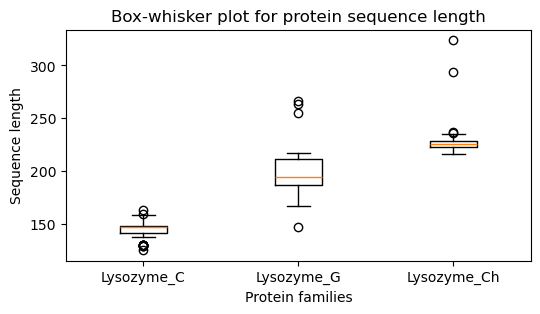

Outlier cut-off for each protein family: {'Lysozyme_C': [137, 158], 'Lysozyme_G': [167, 217], 'Lysozyme_Ch': [216, 235]}
Total number of protein sequences removed as outliers: 20
Total number of protein sequences below cut-off 30: 0

Contingency Matrix for KMeans:


Cluster,Cluster 0,Cluster 1,Cluster 2,Total
Protein family,,,,
Lysozyme_C,2,34,16,52
Lysozyme_Ch,50,0,4,54
Lysozyme_G,0,5,12,17
Total,52,39,32,123



Contingency Matrix for Agglomerative:


Cluster,Cluster 0,Cluster 1,Cluster 2,Total
Protein family,,,,
Lysozyme_C,52,0,0,52
Lysozyme_Ch,0,54,0,54
Lysozyme_G,1,0,16,17
Total,53,54,16,123



Contingency Matrix for Gaussian mixture:


Cluster,Cluster 0,Cluster 1,Cluster 2,Total
Protein family,,,,
Lysozyme_C,2,35,15,52
Lysozyme_Ch,50,0,4,54
Lysozyme_G,0,5,12,17
Total,52,40,31,123



Contingency Matrix for Spectral:


Cluster,Cluster 0,Cluster 1,Cluster 2,Total
Protein family,,,,
Lysozyme_C,2,50,0,52
Lysozyme_Ch,52,0,2,54
Lysozyme_G,0,1,16,17
Total,54,51,18,123



Contingency Matrix for Affinity propagation:


Cluster,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Total
Protein family,,,,,
Lysozyme_C,17,33,0,2,52
Lysozyme_Ch,0,0,3,51,54
Lysozyme_G,0,1,16,0,17
Total,17,34,19,53,123



Contingency Matrix for DBSCAN:


Cluster,Noise,Total
Protein family,,
Lysozyme_C,52,52
Lysozyme_Ch,54,54
Lysozyme_G,17,17
Total,123,123



Contingency Matrix for OPTICS:


Cluster,Noise,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Total
Protein family,,,,,,,
Lysozyme_C,33,5,8,6,0,0,52
Lysozyme_Ch,38,0,0,0,0,16,54
Lysozyme_G,1,0,0,0,16,0,17
Total,72,5,8,6,16,16,123



Contingency Matrix for Mean-shift:


Cluster,Cluster 0,Cluster 1,Cluster 2,Total
Protein family,,,,
Lysozyme_C,50,1,1,52
Lysozyme_Ch,54,0,0,54
Lysozyme_G,17,0,0,17
Total,121,1,1,123



Contingency Matrix for BIRCH:


Cluster,Cluster 0,Total
Protein family,,
Lysozyme_C,52,52
Lysozyme_Ch,54,54
Lysozyme_G,17,17
Total,123,123


Number of subclusters found 1 by BIRCH even though k=3

Summary of clustering results for Lysozyme_CGCCh dataset:


,expected_clusters,predicted_clusters,total_features,total_samples,SC,CH,DB,FMI,F1,MCC,AMI
Clustering_method,,,,,,,,,,,
KMeans,3,3,50,123,0.30,55.45,1.71,0.73,0.73,0.58,0.53
Agglomerative,3,3,50,123,0.29,54.32,1.28,0.99,0.99,0.98,0.96
Gaussian mixture,3,3,50,123,0.30,55.39,1.71,0.74,0.73,0.59,0.53
Spectral,3,3,50,123,0.30,57.83,1.36,0.93,0.93,0.89,0.83
Affinity propagation,3,4,50,123,0.30,48.01,1.53,0.81,0.80,0.72,0.72
DBSCAN,3,1,50,123,NaN,NaN,NaN,0.62,0.56,0.00,0.00
OPTICS,3,6,50,123,-0.00,12.84,1.46,0.53,0.53,0.24,0.46
Mean-shift,3,3,50,123,0.07,1.67,0.82,0.61,0.55,-0.01,-0.00
BIRCH,3,1,50,123,NaN,NaN,NaN,0.62,0.56,0.00,0.00




Note: NaN values indicate that the number of clusters is 1, which is not suitable for calculating intrinsic evaluation metrics.
 -0.00 indicates a very small negative value that has been rounded to 0.00.


In [11]:
print(f'Clustering results for {dataset} dataset')
# Preprocessing steps
# 1) remove duplicates within protein family based on accession number
# 2) remove duplicates between protein families based on accession number
# 3) remove sequences with "UZOBJX" amino acid
preprocessed_fasta = preprocessing_step(protein_families)

# Optional preprocessing steps
# 1) Remove outliers based on the lower and upper bounds for the protein sequences length using box-whisker plot
# 2) Remove the sequence below assigned sequence length cut-off
## a) This sequence length cut-off is done to get feature of same dimension size for clustering
optional_preprocessing_fasta = optional_preprocessing_step(preprocessed_fasta, 30) # 30 is the cut-off for the protein sequence length

# Feature extraction using pseudo amino acid composition (PAAC)
# 1) lambda_ is the sequence order
# 2) w is the weight factor
PAAC = pseudo_amino_acid_composition(optional_preprocessing_fasta.len_filtered_fasta, 30, 0.05) # default lambda_ = 30 and w = 0.05

# Clustering
## 1) KMeans, 2) Agglomerative clustering, 3) Gaussian mixture, 4) Spectral clustering, 5) Affinity propagation, 6) DBSCAN, 7) OPTICS, 8) Mean-shift, 9) BIRCH
# Evaluation metrics
## 1) Intrinsic: Silhouette coefficient, Calinski-Harabasz index, Davies-Bouldin index
## 2) Extrinsic: Fowlkes-Mallows index, F1 score, Matthews correlation coefficient, Adjusted mutual information  
## 3) Contingency matrix
clustering_results = clustering(PAAC.df, 3) # 3 is the number of clusters
kmeans_results = clustering_results.kmeans()
agglomerative_results = clustering_results.agglomerative()
gaussian_mixture_results = clustering_results.gaussian_mixture()
spectral_results = clustering_results.spectral()
affinity_propagation_results = clustering_results.affinity_propagation()
dbscan_results = clustering_results.dbscan()
optics_results = clustering_results.optics()
mean_shift_results = clustering_results.mean_shift()
birch_results = clustering_results.birch()

# Summary of clustering results
clustering_summary = pd.DataFrame([kmeans_results, agglomerative_results, gaussian_mixture_results, spectral_results, 
                                   affinity_propagation_results, dbscan_results, optics_results, mean_shift_results, birch_results])
# Set clustering_summary index to Clustering_method column and drop the original column
clustering_summary.set_index('Clustering_method', inplace=True)
print(f'\nSummary of clustering results for {dataset} dataset:')
display(clustering_summary)
print('\n')
print('Note: NaN values indicate that the number of clusters is 1, which is not suitable for calculating intrinsic evaluation metrics.\n -0.00 indicates a very small negative value that has been rounded to 0.00.')